<a href="https://colab.research.google.com/github/yckamra/MLOps-Animal-Classifier/blob/main/notebooks/animals10_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Installing project dependencies...")
!pip install numpy pandas scipy scikit-learn matplotlib # Basic libraries we want
!pip install tensorflow
!pip install torch
!pip install mlflow
print("Dependencies installed successfully.")

Installing project dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Succ

In [25]:
import os # For file manipulation
import torch # Machine learning library
import matplotlib.pyplot as plt # For graphing
import numpy as np # For math library and matrices
from sklearn.metrics import classification_report
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import random
import tensorflow as tf
from google.colab import auth
import torchvision.models as models
import torchvision.models as tv_models
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient
from google.cloud import storage

In [3]:
print(torch.cuda.is_available()) # See if cuda GPU is accessible

True


In [4]:
auth.authenticate_user()

!gcloud config set project mlops-animal-classifier

!gsutil -m cp -r gs://mlops-animal-classifier/raw_data/* /content/

Streaming output truncated to the last 5000 lines.
Copying gs://mlops-animal-classifier/raw_data/ragno/OIP-MV0B39uLpdjh2XM_u3W_JQHaE8.jpeg...
Copying gs://mlops-animal-classifier/raw_data/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg...
Copying gs://mlops-animal-classifier/raw_data/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg...
Copying gs://mlops-animal-classifier/raw_data/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg...
Copying gs://mlops-animal-classifier/raw_data/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg...
Copying gs://mlops-animal-classifier/raw_data/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg...
Copying gs://mlops-animal-classifier/raw_data/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg...
Copying gs://mlops-animal-classifier/raw_data/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg...
Copying gs://mlops-animal-classifier/raw_data/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg...
Copying gs://mlops-animal-classifier/raw_data/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg...
Copying gs://mlops-animal-classifier/ra

In [5]:
!ls /content/

cane	 elefante  gallina  mucca   ragno	 scoiattolo
cavallo  farfalla  gatto    pecora  sample_data


In [8]:
# Load ResNet34 with pretrained ImageNet weights
weights = tv_models.ResNet34_Weights.IMAGENET1K_V1
model = models.resnet34(weights=weights)

# Replace the final fully connected layer to match your number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 classes for Animal10

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 37.5MB/s]


In [9]:
EXPERIMENT_NAME = "animal_classifier_gcs"
ARTIFACT_URI = "gs://mlops-animal-classifier/models"

# Only create if it doesn't already exist
if not mlflow.get_experiment_by_name(EXPERIMENT_NAME):
    mlflow.create_experiment(name=EXPERIMENT_NAME, artifact_location=ARTIFACT_URI)

# Always set the experiment before starting a run
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='gs://mlops-animal-classifier/models', creation_time=1752272598124, experiment_id='295126241720845328', last_update_time=1752272598124, lifecycle_stage='active', name='animal_classifier_gcs', tags={}>

In [11]:
# Setting the seeds to ensure the same results
seed = 42
torch.manual_seed(seed)        # PyTorch seed for CPU
torch.cuda.manual_seed(seed)   # PyTorch seed for current GPU
torch.cuda.manual_seed_all(seed)  # PyTorch seed for all GPUs (if using multiple)
np.random.seed(seed)           # NumPy seed

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

In [12]:
def get_image_paths(directory, extensions=None):

    if extensions is None:
        extensions = ('.jpg', '.png', '.jpeg')

    # Get all image file paths in the directory
    image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith(extensions)]

    return image_paths

In [13]:
dog_paths = get_image_paths("/content/cane/")
horse_paths = get_image_paths("/content/cavallo/")
elephant_paths = get_image_paths("/content/elefante/")
butterfly_paths = get_image_paths("/content/farfalla/")
chicken_paths = get_image_paths("/content/gallina/")
cat_paths = get_image_paths("/content/gatto/")
cow_paths = get_image_paths("/content/mucca/")
sheep_paths = get_image_paths("/content/pecora/")
squirrel_paths = get_image_paths("/content/scoiattolo/")
spider_paths = get_image_paths("/content/ragno/")

In [14]:
print(f"Number of DOG images: {len(dog_paths)}")
print(f"Number of HORSE images: {len(horse_paths)}")
print(f"Number of ELEPHANT images: {len(elephant_paths)}")
print(f"Number of BUTTERFLY images: {len(butterfly_paths)}")
print(f"Number of CHICKEN images: {len(chicken_paths)}")
print(f"Number of CAT images: {len(cat_paths)}")
print(f"Number of COW images: {len(cow_paths)}")
print(f"Number of SHEEP images: {len(sheep_paths)}")
print(f"Number of SQUIRREL images: {len(squirrel_paths)}")
print(f"Number of SPIDER images: {len(spider_paths)}")

Number of DOG images: 4863
Number of HORSE images: 2623
Number of ELEPHANT images: 1446
Number of BUTTERFLY images: 2112
Number of CHICKEN images: 3098
Number of CAT images: 1668
Number of COW images: 1866
Number of SHEEP images: 1820
Number of SQUIRREL images: 1862
Number of SPIDER images: 4821


In [15]:
dog_labels = [0] * len(dog_paths)
horse_labels = [1] * len(horse_paths)
elephant_labels = [2] * len(elephant_paths)
butterfly_labels = [3] * len(butterfly_paths)
chicken_labels = [4] * len(chicken_paths)
cat_labels = [5] * len(cat_paths)
cow_labels = [6] * len(cow_paths)
sheep_labels = [7] * len(sheep_paths)
squirrel_labels = [8] * len(squirrel_paths)
spider_labels = [9] * len(spider_paths)

all_paths = dog_paths + horse_paths + elephant_paths + butterfly_paths + chicken_paths + cat_paths + cow_paths + sheep_paths + squirrel_paths + spider_paths
all_labels = dog_labels + horse_labels + elephant_labels + butterfly_labels + chicken_labels + cat_labels + cow_labels + sheep_labels + squirrel_labels + spider_labels

# Shuffle our training data
all_paths, all_labels = shuffle(all_paths, all_labels, random_state=42)

# First split into 70% train and 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    all_paths, all_labels, test_size=0.3, random_state=42, stratify=all_labels)

# Now split temp into 15% val and 15% test (i.e., 0.5 of 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [16]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        path = self.image_paths[index]

        # Open the GCS image file using TensorFlow's gfile
        with tf.io.gfile.GFile(path, 'rb') as f:
            image = Image.open(f).convert('RGB')

        # Apply preprocessing transforms
        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        return image, label

# Preprocessing transformations for ResNet input
preprocess = transforms.Compose([
  transforms.Resize(256),               # Resize to 256 pixels on shorter side
  transforms.CenterCrop(224),           # Crop center to 224x224
  transforms.ToTensor(),                # Convert to PyTorch tensor
  transforms.Normalize(                 # Normalize using ImageNet mean and std
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  ),
])
# Create dataset
train_dataset = ImageDataset(X_train, y_train, transform=preprocess)
val_dataset = ImageDataset(X_val, y_val, transform=preprocess)
test_dataset = ImageDataset(X_test, y_test, transform=preprocess)

In [17]:
# Setting hyperparameters
num_epochs = 10
learning_rate = 0.001
batch_size = 64
momentum=0.4 # This is for SGD if decided to be the best optimizer (our evaluation shows it is not)
weight_decay=1e-4

# Model optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2) # Patience of 3 may be a little too aggressive

# Loss function creation
criterion = nn.CrossEntropyLoss()

# Set epoch number to zero
epoch_num = 0

# DataLoader for test data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g)
cross_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g)

# Lists for train and CV accuracies and losses
train_accuracies = []
train_losses = []
cross_accuracies = []
cross_losses = []

In [18]:
def calculate_accuracy(model, dataloader, device):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)  # Multiply by batch size
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / total  # Average loss per sample

    return accuracy, avg_loss

In [19]:
with mlflow.start_run():

  mlflow.log_param("learning_rate", learning_rate)
  mlflow.log_param("batch_size", batch_size)
  mlflow.log_param("weight_decay", weight_decay)
  mlflow.log_param("num_epochs", num_epochs)

  # Put the model into the GPU
  if torch.cuda.is_available():
    model.to('cuda')

  # Training loop
  for epoch in range(num_epochs):

      # Set the model to training mode
      model.train()

      for batch_images, batch_labels in train_loader:
          # Move data to GPU
          if torch.cuda.is_available():
              batch_images = batch_images.to('cuda')
              batch_labels = batch_labels.to('cuda')

          # Zero the gradients as this is a new batch
          optimizer.zero_grad()

          # Forward pass
          outputs = model(batch_images)

          # Calculate loss
          loss = criterion(outputs, batch_labels)

          # Backward pass
          loss.backward()

          # Gradient clipping to prevent exploding gradients (limits how big gradients can be)
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

          # Step with our optimizer
          optimizer.step()

      epoch_num += 1

      # Move the model to GPU if available
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

      # Get our accuracies and losses, then store inside our lists
      train_accuracy, train_loss = calculate_accuracy(model, train_loader, device)
      cross_accuracy, cross_loss = calculate_accuracy(model, cross_loader, device)
      train_accuracies.append(train_accuracy)
      train_losses.append(train_loss)
      cross_accuracies.append(cross_accuracy)
      cross_losses.append(cross_loss)

      mlflow.log_metric("train_loss", train_loss, step=epoch)
      mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)
      mlflow.log_metric("val_loss", cross_loss, step=epoch)
      mlflow.log_metric("val_accuracy", cross_accuracy, step=epoch)

      # Step the scheduler using the cross-validation loss
      scheduler.step(cross_loss)

      print(f"Epoch [{epoch+1}/{num_epochs}]:")

      # Print train loss and accuracy
      print(f'Train Loss: {train_loss / len(train_loader):.4f}')
      print(f'Train Accuracy: {train_accuracy:.2f}%')

      # Print test loss and accuracy
      print(f'Cross-Validation Loss: {cross_loss / len(cross_loader):.4f}')
      print(f'Cross-Validation Accuracy: {cross_accuracy:.2f}%\n')

  mlflow.pytorch.log_model(model, "ResNet34_Animal10")

Epoch [1/10]:
Train Loss: 0.0022
Train Accuracy: 79.11%
Cross-Validation Loss: 0.0115
Cross-Validation Accuracy: 76.85%

Epoch [2/10]:
Train Loss: 0.0019
Train Accuracy: 82.76%
Cross-Validation Loss: 0.0103
Cross-Validation Accuracy: 80.32%

Epoch [3/10]:
Train Loss: 0.0011
Train Accuracy: 89.90%
Cross-Validation Loss: 0.0077
Cross-Validation Accuracy: 84.95%

Epoch [4/10]:
Train Loss: 0.0011
Train Accuracy: 90.58%
Cross-Validation Loss: 0.0084
Cross-Validation Accuracy: 84.85%

Epoch [5/10]:
Train Loss: 0.0008
Train Accuracy: 92.14%
Cross-Validation Loss: 0.0078
Cross-Validation Accuracy: 85.51%

Epoch [6/10]:
Train Loss: 0.0010
Train Accuracy: 91.13%
Cross-Validation Loss: 0.0092
Cross-Validation Accuracy: 82.86%

Epoch [7/10]:
Train Loss: 0.0001
Train Accuracy: 99.40%
Cross-Validation Loss: 0.0045
Cross-Validation Accuracy: 91.62%

Epoch [8/10]:
Train Loss: 0.0001
Train Accuracy: 99.18%
Cross-Validation Loss: 0.0053
Cross-Validation Accuracy: 90.60%

Epoch [9/10]:
Train Loss: 0.0002

2025/07/11 22:58:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 22:58:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch [10/10]:
Train Loss: 0.0001
Train Accuracy: 99.11%
Cross-Validation Loss: 0.0065
Cross-Validation Accuracy: 90.12%



2025/07/11 22:59:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/11 22:59:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [20]:
def graph_metric(train_list, cross_list, epoch_num, loss_or_accuracy_string):

    plt.plot(range(1, epoch_num + 1), train_list, marker='o', linestyle='-', color='b', label='train')
    plt.plot(range(1, epoch_num + 1), cross_list, marker='o', linestyle='-', color='r', label='cross-validation')
    plt.title(f'Model {loss_or_accuracy_string} Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(loss_or_accuracy_string)
    plt.grid(True)
    plt.legend()
    plt.show()

# Gets predictions of loader data on our model
def collect_predictions_and_targets(loader, model):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():  # No need for gradients during evaluation
        for batch_features, batch_targets in loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                batch_features = batch_features.to('cuda')
                batch_targets = batch_targets.to('cuda')

            # Forward pass to get predictions
            outputs = model(batch_features)

            # Get predicted class (argmax)
            _, preds = torch.max(outputs, dim=1)

            # Store predictions and targets
            all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to NumPy
            all_targets.extend(batch_targets.cpu().numpy())

    return all_preds, all_targets

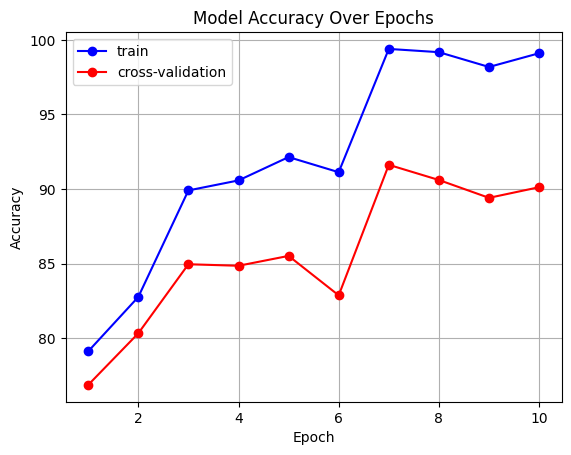

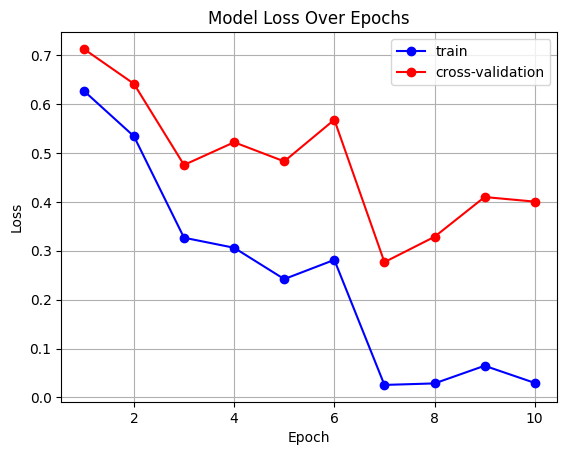

Train Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3404
           1       0.96      1.00      0.98      1836
           2       1.00      1.00      1.00      1012
           3       1.00      0.99      0.99      1478
           4       0.99      1.00      1.00      2169
           5       1.00      0.99      1.00      1168
           6       0.99      0.99      0.99      1306
           7       1.00      0.96      0.98      1274
           8       0.99      1.00      0.99      1303
           9       0.99      1.00      1.00      3375

    accuracy                           0.99     18325
   macro avg       0.99      0.99      0.99     18325
weighted avg       0.99      0.99      0.99     18325

Cross-Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       729
           1       0.82      0.94      0.88       394
 

In [21]:
graph_metric(train_accuracies, cross_accuracies, epoch_num, 'Accuracy')
graph_metric(train_losses, cross_losses, epoch_num, 'Loss')

# Collect train predictions and labels
train_preds, train_targets = collect_predictions_and_targets(train_loader, model)

# Collect test predictions and labels
cross_preds, cross_targets = collect_predictions_and_targets(cross_loader, model)

# Generate classification report
train_report = classification_report(train_targets, train_preds)
cross_report = classification_report(cross_targets, cross_preds)

# Print the report
print("Train Set Classification Report:")
print(train_report)
print("Cross-Validation Set Classification Report:")
print(cross_report)

In [22]:
# Collect test predictions and labels
test_preds, test_targets = collect_predictions_and_targets(test_loader, model)

# Generate classification report
test_report = classification_report(test_targets, test_preds)

# Print the report
print("Test Set Classification Report:")
print(test_report)

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       730
           1       0.79      0.94      0.86       393
           2       0.93      0.86      0.89       217
           3       0.91      0.89      0.90       317
           4       0.89      0.92      0.91       465
           5       0.95      0.85      0.89       250
           6       0.87      0.80      0.83       280
           7       0.95      0.77      0.85       273
           8       0.86      0.90      0.88       279
           9       0.90      0.96      0.93       723

    accuracy                           0.89      3927
   macro avg       0.89      0.88      0.88      3927
weighted avg       0.89      0.89      0.89      3927



In [23]:
model_save_path = '/content/resnet34_model.pth'
torch.save(model.state_dict(), model_save_path)

def upload_file_to_gcs(local_file_path: str, bucket_name: str, destination_blob_name: str):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(local_file_path)
    print(f"Uploaded {local_file_path} to gs://{bucket_name}/{destination_blob_name}")

bucket_name = "mlops-animal-classifier"
blob_name = "models/resnet32_model.pth"

upload_file_to_gcs(model_save_path, bucket_name, blob_name)

Uploaded /content/resnet34_model.pth to gs://mlops-animal-classifier/models/resnet32_model.pth
